In [57]:
# Biblioteki

import eurostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [58]:
# Konfiguracja

# Wskaźniki
indicators = {
    'nrg_ind_ren': 'OZE_Share',           # Udział OZE w końcowym zużyciu energii [%]
    'nrg_ind_ei':  'Energy_Intensity',    # Energochłonność (kgoe / 1000 EUR)
    'nrg_ind_id':  'Import_Dependency',   # Zależność importowa [%]
}

# Statystyki balansu energetycznego
stats = {
    "nrg_ind_ren": {"nrg_bal": "REN"},           # ogólnie (bez podziału transport, elektryczność itp.)
    "nrg_ind_ei":  {"nrg_bal": "EI_GDP_PPS"}, # w standardzie siły nabywczej
    "nrg_ind_id": {'siec':  'TOTAL'}   # Całkowita (bez podziału węgiel itp.)
}

# Określenie charakteru zmiennych
# S - Stymulanta, D - Destymulanta
variable_types = {
    'OZE_Share': 'S',
    'Energy_Intensity': 'D',
    'Import_Dependency': 'D',
}

GEO = 'PL'

In [59]:
def fetch_and_clean(code, name, geo, stats = stats):
    df = eurostat.get_data_df(code)
    df = df[df['geo\\TIME_PERIOD'] == geo]
    
    key = list(stats[code].keys())[0]
    value = list(stats[code].values())[0]
    df = df[df[key] == value]
            
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df = df[year_cols]
    
    df = df.T
    df.columns = [name]
    df.index.name = 'Rok'
    df.index = df.index.astype(int)
    df = df.sort_index()
    
    return df

In [60]:
# Pobieranie danych
print("Łączenie z API Eurostat...")

dfs = []
for code, name in indicators.items():
    print(f"  - Pobieranie: {name} ({code})")
    d = fetch_and_clean(code, name, GEO)
    dfs.append(d)

data = pd.concat(dfs, axis=1).dropna()
print(f"\nZgromadzono dane dla lat: {data.index.min()} - {data.index.max()}")
print(data.head())
print('Liczba obserwacji:', len(data))
print('Liczba zmiennych diagnostycznych:', len(data.columns))

Łączenie z API Eurostat...
  - Pobieranie: OZE_Share (nrg_ind_ren)
  - Pobieranie: Energy_Intensity (nrg_ind_ei)
  - Pobieranie: Energy_Intensity (nrg_ind_ei)
  - Pobieranie: Import_Dependency (nrg_ind_id)
  - Pobieranie: Import_Dependency (nrg_ind_id)

Zgromadzono dane dla lat: 2004 - 2023
      OZE_Share  Energy_Intensity  Import_Dependency
Rok                                                 
2004      6.882            219.23             14.727
2005      6.867            213.32             17.748
2006      6.859            212.21             20.149
2007      6.903            192.31             25.790
2008      7.686            181.36             30.862
Liczba obserwacji: 20
Liczba zmiennych diagnostycznych: 3

Zgromadzono dane dla lat: 2004 - 2023
      OZE_Share  Energy_Intensity  Import_Dependency
Rok                                                 
2004      6.882            219.23             14.727
2005      6.867            213.32             17.748
2006      6.859            2

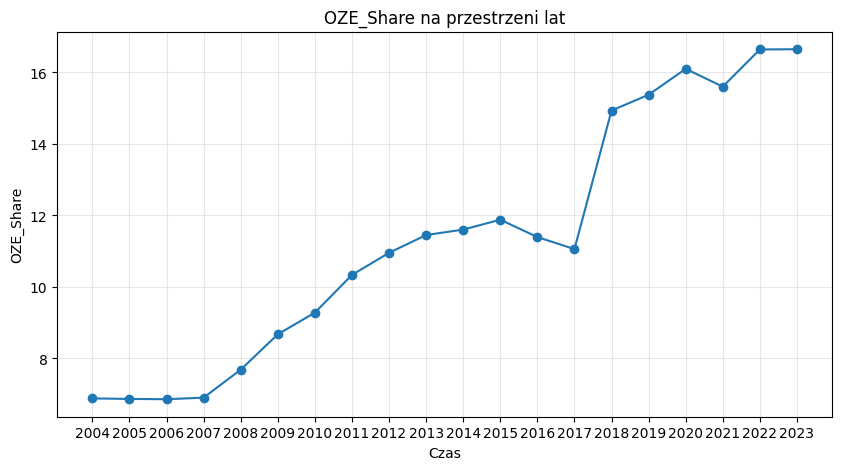

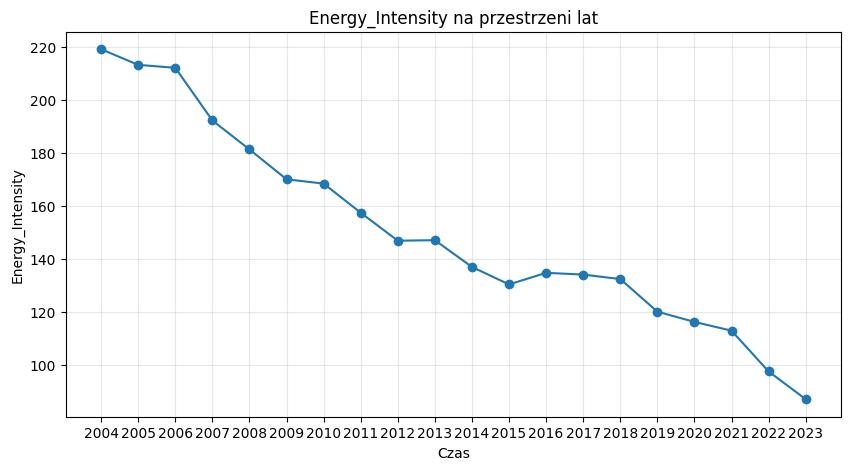

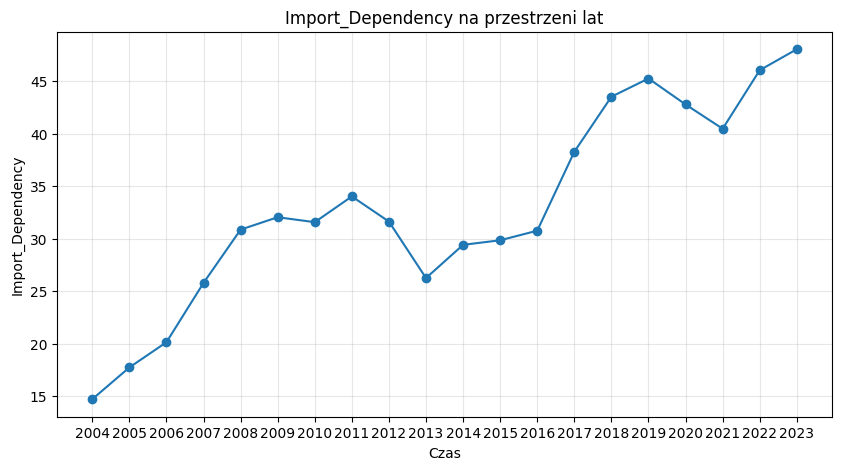

In [61]:
for _, v in indicators.items():
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[v], marker='o')
    plt.title(f'{v} na przestrzeni lat')
    plt.xlabel('Czas')
    plt.ylabel(v)
    plt.xticks(range(data.index.min(), data.index.max() + 1))
    plt.grid(alpha=0.3)
    plt.show()


In [62]:
# Zamiana destymulant na stymulanty - czy potrzebne
for col, v_type in variable_types.items():
    if col in data.columns and v_type == 'D':
        data[col] = -1 * data[col]

In [63]:
# 3. Standaryzacja (z-score) i podgląd
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
print('\nPrzykładowe wiersze po standaryzacji:')
print(df_std.head())


Przykładowe wiersze po standaryzacji:
      OZE_Share  Energy_Intensity  Import_Dependency
Rok                                                 
2004  -1.313056         -1.844228           1.976081
2005  -1.317457         -1.685605           1.648579
2006  -1.319804         -1.655813           1.388290
2007  -1.306896         -1.121702           0.776758
2008  -1.077181         -0.827806           0.226910


In [64]:
# 4. Konstrukcja indeksów agregatowych
# --- a) Equal Weighting (srednia standaryzowanych)
data["equal_weighting"] = df_std.mean(axis=1)


In [65]:
# --- b) PCA (główna składowa) standaryzowanych
pca = PCA(n_components=1)
pca_result = pca.fit_transform(df_std)

data['PCA'] = pca_result

In [ ]:
# --- c) Entropy Weighting Method (normalizacja MinMax)
minmax = MinMaxScaler()
df_norm = pd.DataFrame(minmax.fit_transform(data[indicators.values()]), columns=indicators.values(), index=data.index)

P = df_norm / (df_norm.sum(axis=0) + 1e-8)
P = np.where(P == 0, 1e-10, P)
E = (-P * np.log(P)).mean(axis=0) / np.log(len(data))
d = 1 - E
ewm_weights = d / d.sum()
data["entropy_weighting"] = (df_norm * ewm_weights).sum(axis=1)


Wagi EWM: {'OZE_Share': np.float64(0.3339), 'Energy_Intensity': np.float64(0.333), 'Import_Dependency': np.float64(0.3331)}


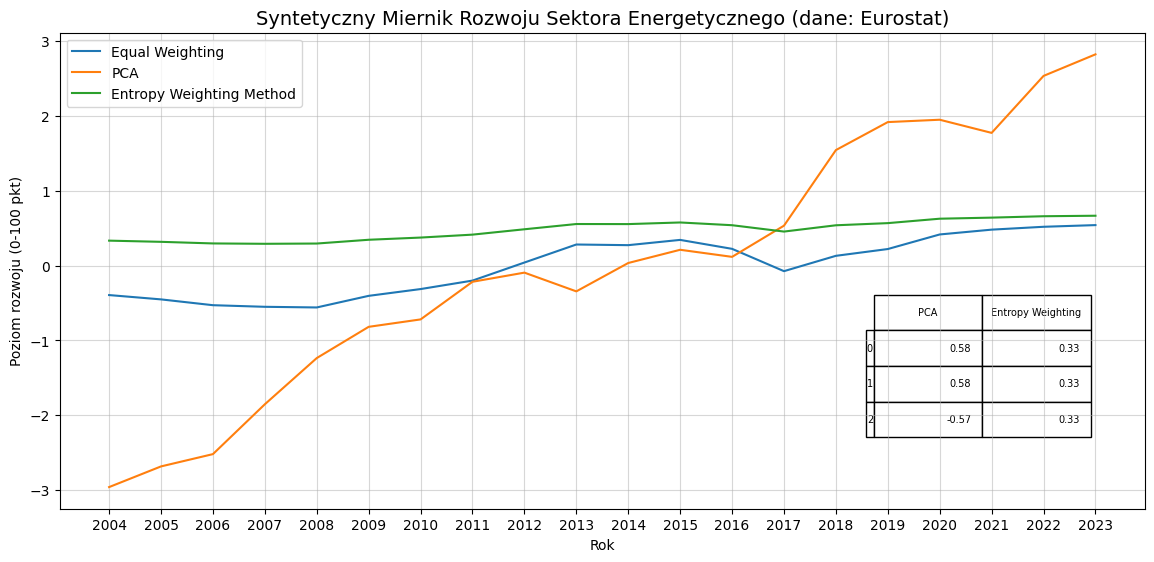


--- Ładunki czynnikowe (korelacja zmiennych z miernikiem) ---
        PCA  Entropy Weighting
0  0.580801           0.333923
1  0.581098           0.332955
2 -0.570083           0.333122


In [ ]:
plt.figure(figsize=(14, 7))

# Wykres główny
sns.lineplot(x=data.index, y=data['equal_weighting'], label='Equal Weighting')
sns.lineplot(x=data.index, y=data['PCA'], label='PCA')
sns.lineplot(x=data.index, y=data['entropy_weighting'], label='Entropy Weighting Method')

plt.title(f'Syntetyczny Miernik Rozwoju Sektora Energetycznego (dane: Eurostat)', fontsize=14)
plt.ylabel('Poziom rozwoju (0-100 pkt)')
plt.xlabel('Rok')
plt.xticks(range(data.index.min(), data.index.max() + 1))
plt.legend()


# Tabela z wagami (ładunki czynnikowe)
indicator_cols = list(indicators.values())
loadings = pd.DataFrame(
    {
        'PCA': pca.components_[0],
        'Entropy Weighting': ewm_weights
    }
)

plt.table(cellText=np.round(loadings.values, 2),
          rowLabels=loadings.index,
          colLabels=loadings.columns,
          loc='bottom', bbox=[0.75, 0.15, 0.2, 0.3])
plt.subplots_adjust(bottom=0.2)
plt.grid(True, which='major', alpha=0.5)

plt.show()